# Gesture Recognition Project
This project involves building a 3D Convolutional Neural Network (CNN) to correctly recognize hand gestures by a user to control a smart TV.

The objective of this projects is to build a hand gesture recognition model that can be hosted on a camera installed in a smart TV that can understand 5 gestures. 

The gestures are continuously monitored by the webcam mounted on the TV. Each gesture corresponds to a specific command:
-	Thumbs up:  Increase the volume
-	Thumbs down: Decrease the volume
-	Left swipe: 'Jump' backwards 10 seconds
-	Right swipe: 'Jump' forward 10 seconds  
-	Stop: Pause the movie


In [1]:
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GRU, Flatten, TimeDistributed, BatchNormalization, Activation, Dropout
from tensorflow.keras.layers import Conv3D, MaxPooling3D, Conv2D, MaxPooling2D, LSTM
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras import optimizers
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.optimizers import Adam, SGD


In [2]:
# Importing the python basic libraries and functions:
import numpy as np
import os
#from scipy.misc import imread, imresize
import datetime
import os

# Importing additional libraries which might be needed for image pre-processing :

#import resize as imresize
#import sckikit-image as skimage
import cv2
import imageio as imio
from PIL import Image

In [3]:
# Random seed is done to handle the reproducibility of the network and so that the results don't vary drastically:

In [4]:
# Import libraries
import numpy as np
import random as rn
import tensorflow as tf
from keras import backend as K
import matplotlib.pyplot as plt

# Set random seeds for reproducibility
np.random.seed(30)
rn.seed(30)
tf.random.set_seed(30)

# Enable inline plotting
%matplotlib inline

In [5]:
# Check the Tensor flow version :

tf.__version__

'2.7.0'

In [6]:
import tensorflow as tf

# Allow memory growth on the GPU
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        # Set memory growth to True for all GPUs
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)  # Memory growth must be set at program startup

In this block, you read the folder names for training and validation. You also set the `batch_size` here. Note that you set the batch size in such a way that you are able to use the GPU in full capacity. You keep increasing the batch size until the machine throws an error.

In [7]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

# Experiment with the batch size
batch_size = 25

In [8]:
# Custom function to crop image :

def crop_img(img, scale=1.0):
    center_x, center_y = img.shape[1] / 2, img.shape[0] / 2
    width_scaled, height_scaled = img.shape[1] * scale, img.shape[0] * scale
    left_x, right_x = center_x - width_scaled / 2, center_x + width_scaled / 2
    top_y, bottom_y = center_y - height_scaled / 2, center_y + height_scaled / 2
    img_cropped = img[int(top_y):int(bottom_y), int(left_x):int(right_x)]
    return img_cropped

## Generator
This is one of the most important part of the code. The overall structure of the generator has been given. In the generator, you are going to preprocess the images as you have images of 2 different dimensions as well as create a batch of video frames. 

In [9]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [0,1,2,4,6,8,10,12,14,16,18,20,22,24,26,27,28,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,64,64,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.10)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,64,64,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.10)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(64,64),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


Note here that a video is represented above in the generator as (number of images, height, width, number of channels). Take this into consideration while creating the model architecture.

In [10]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 5
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 5


## Model
Here you make the model using different functionalities that Keras provides. Remember to use `Conv3D` and `MaxPooling3D` and not `Conv2D` and `Maxpooling2D` for a 3D convolution model. You would want to use `TimeDistributed` while building a Conv2D + RNN model. Also remember that the last layer is the softmax. Design the network in such a way that the model is able to give good accuracy on the least number of parameters so that it can fit in the memory of the webcam.

### Model : 1-Conv 3D Model 
#### Without dropouts & with batch normalization

##### Input size 64X64 , adam optimiser-0.0002,5-epochs, 25-batch size 

In [10]:
# Building the first model which is 3D Conv model:

modelConv3D_1 = Sequential()

modelConv3D_1.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,64,64,3)))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_1.add(Activation('relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Flatten())
modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(64, activation='relu'))
modelConv3D_1.add(BatchNormalization())
modelConv3D_1.add(Dropout(0.25))

modelConv3D_1.add(Dense(5, activation='softmax'))

2024-11-06 09:58:37.020598: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22855 MB memory:  -> device: 0, name: Quadro RTX 6000, pci bus id: 0000:3f:00.0, compute capability: 7.5


In [11]:
import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.mixed_precision import experimental as mixed_precision

# Set mixed precision policy
policy = mixed_precision.Policy('mixed_float16')
mixed_precision.set_policy(policy)

# Define the Adam optimizer
optimiser = optimizers.Adam(learning_rate=0.0002)

# Wrap the optimizer with LossScaleOptimizer, using dynamic loss scaling
optimiser = mixed_precision.LossScaleOptimizer(optimiser, loss_scale='dynamic')

# Compile your model
modelConv3D_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(modelConv3D_1.summary())

INFO:tensorflow:Mixed precision compatibility check (mixed_float16): OK
Your GPU will likely run quickly with dtype policy mixed_float16 as it has compute capability of at least 7.0. Your GPU: Quadro RTX 6000, compute capability 7.5
Instructions for updating:
Use tf.keras.mixed_precision.LossScaleOptimizer instead. LossScaleOptimizer now has all the functionality of DynamicLossScale
  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 18, 64, 64, 8)     656       
                                                                 
 activation (Activation)     (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization (BatchN  (None, 18, 64, 64, 8)    32        
 ormalization)                                                   
         

In [12]:
print("Total Params in model:", modelConv3D_1.count_params())

Total Params in model: 144421


Now that you have written the model, the next step is to `compile` the model. When you print the `summary` of the model, you'll see the total number of parameters you have to train.

In [75]:
#write your optimizer
#optimiser = 
#sgd = optimizers.SGD(lr=0.001, decay=1e-6, momentum=0.7, nesterov=True)
#model.compile(optimizer=sgd, loss='categorical_crossentropy', metrics=['categorical_accuracy'])
#print (model.summary())

Let us create the `train_generator` and the `val_generator` which will be used in `.fit_generator`.

In [13]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [14]:
# Get the current date and time for model saving
curr_dt_time = datetime.datetime.now()

# Create model name with current timestamp
model_name = 'model_init_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Check if the directory exists, and create if not
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

# Combine callbacks into a list
callbacks_list = [checkpoint, LR]

The `steps_per_epoch` and `validation_steps` are used by `fit_generator` to decide the number of next() calls it need to make.

In [15]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

Let us now fit the model. This will start training the model and with the help of the checkpoints, you'll be able to save the model at the end of each epoch.

In [16]:
# Modified the fit generator to use multiproessing to improve the training time :

# This is for first model 3D Conv model: (modelConv3D_1)

history = modelConv3D_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,
                    workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 25
Epoch 1/5


2024-11-06 09:59:07.178896: I tensorflow/stream_executor/cuda/cuda_dnn.cc:377] Loaded cuDNN version 8302


27/27 [==============================] - ETA: 0s - loss: 2.1595 - categorical_accuracy: 0.2368Source path =  /home/datasets/Project_data/val ; batch size = 25

Epoch 00001: saving model to model_init_2024-11-0609_58_58.233644/model-00001-2.15950-0.23680-1.60781-0.23000.h5
27/27 [==============================] - 48s 2s/step - loss: 2.1595 - categorical_accuracy: 0.2368 - val_loss: 1.6078 - val_categorical_accuracy: 0.2300 - lr: 2.0000e-04
Epoch 2/5
27/27 [==============================] - ETA: 0s - loss: 1.8950 - categorical_accuracy: 0.3047
Epoch 00002: saving model to model_init_2024-11-0609_58_58.233644/model-00002-1.89498-0.30468-1.63557-0.20000.h5
27/27 [==============================] - 25s 973ms/step - loss: 1.8950 - categorical_accuracy: 0.3047 - val_loss: 1.6356 - val_categorical_accuracy: 0.2000 - lr: 2.0000e-04
Epoch 3/5
27/27 [==============================] - ETA: 0s - loss: 1.7694 - categorical_accuracy: 0.3363
Epoch 00003: saving model to model_init_2024-11-0609_58_58.23

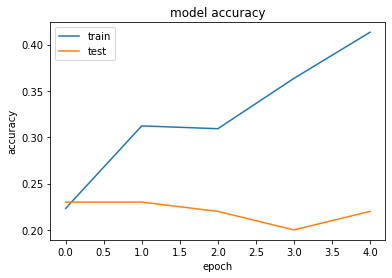

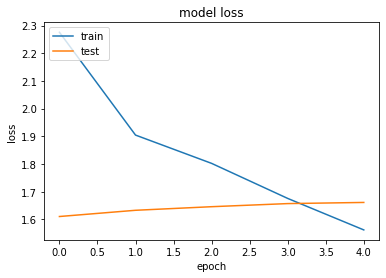

In [80]:
# Plotting the result of Model 1 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [81]:
#Training Accuracy -38 % , Validation Accuracy-21%

###  Model 2 : Conv 3D Model  
#### Current Model Inputs
- Without dropouts & with batch normalization.
- Input image size 64X64 , adam optimiser- 0.0002 without decay
- Changed droput to 0.50 from 0.25 in 1st dense layer 

In [82]:
batch_size = 16
num_epochs = 24

In [83]:
# Building the second model which is 3D Conv model:

modelConv3D_2 = Sequential()

modelConv3D_2.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,64,64,3)))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_2 layer 2

modelConv3D_2.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_2 layer 3

modelConv3D_2.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_2 layer 4

modelConv3D_2.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_2.add(Activation('relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_2.add(Dropout(0.50))

modelConv3D_2.add(Flatten())
modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.50))

modelConv3D_2.add(Dense(64, activation='relu'))
modelConv3D_2.add(BatchNormalization())
modelConv3D_2.add(Dropout(0.50))

modelConv3D_2.add(Dense(5, activation='softmax'))

In [84]:
import tensorflow as tf
from tensorflow.keras import optimizers

# Define the Adam optimizer with a fixed learning rate
optimiser = optimizers.Adam(learning_rate=0.0002)  # No decay applied here

# Define your model (make sure your modelConv3D_1 is defined before this)
modelConv3D_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(modelConv3D_2.summary())


  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_20 (Conv3D)          (None, 18, 64, 64, 8)     656       
                                                                 
 activation_20 (Activation)  (None, 18, 64, 64, 8)     0         
                                                                 
 batch_normalization_27 (Bat  (None, 18, 64, 64, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_20 (MaxPoolin  (None, 9, 32, 32, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_21 (Conv3D)          (None, 9, 32, 32, 16)     3472      
                                                              

In [85]:
print("Total Params in model:", modelConv3D_2.count_params())

Total Params in model: 144421


In [86]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [87]:
# Get the current date and time for model saving
curr_dt_time = datetime.datetime.now()

# Create model name with current timestamp
model_name = 'model_init_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Check if the directory exists, and create if not
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

# Combine callbacks into a list
callbacks_list = [checkpoint, LR]

In [88]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [89]:
#Model Fit

history = modelConv3D_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,
                    workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/24
42/42 [==============================] - ETA: 0s - loss: 2.5734 - categorical_accuracy: 0.2112Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: saving model to model_init_2024-11-0606_03_42.713072/model-00001-2.57336-0.21116-1.66469-0.18000.h5
42/42 [==============================] - 25s 570ms/step - loss: 2.5734 - categorical_accuracy: 0.2112 - val_loss: 1.6647 - val_categorical_accuracy: 0.1800 - lr: 2.0000e-04
Epoch 2/24
42/42 [==============================] - ETA: 0s - loss: 2.4331 - categorical_accuracy: 0.2655
Epoch 00002: saving model to model_init_2024-11-0606_03_42.713072/model-00002-2.43310-0.26546-1.69809-0.19000.h5
42/42 [==============================] - 23s 561ms/step - loss: 2.4331 - categorical_accuracy: 0.2655 - val_loss: 1.6981 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/24
42/42 [==============================] - ETA: 0s - loss: 2.2708 - categor

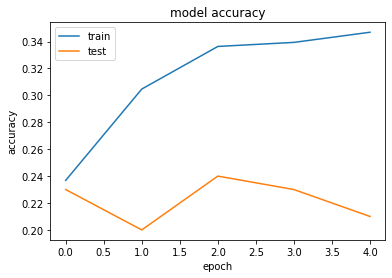

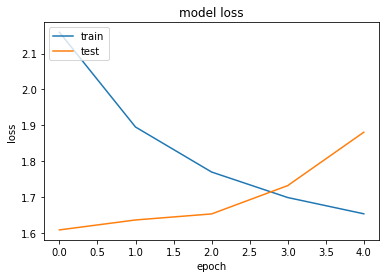

In [ ]:
# Plotting the result of Model 2 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [91]:
#Training Accuracy-39%, Validation Accuracy-34%

###  Model 3 : Conv 3D Model  
#### Current Model Inputs
- image size increaed to 84X84, reduced cropping to 3 % from 10 %
- Without dropouts in Conv layer and with batch normalization.
- adam optimiser- 0.0002 without decay
- Reverted back dropout from 0.50 to 0.25 
- 20 epochs and 24 batch size

In [92]:
# Modified generator function :

def generator_modified(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,84,84,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 3 % of original size :
                    image = crop_img(image, 0.03)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 3 % of original size :
                    image = crop_img(image, 0.03)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [93]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# choose the number of epochs & batch size
num_epochs = 20
print ('# epochs =', num_epochs)
batch_size = 24
print ('# batch_size =', batch_size)

# training sequences = 663
# validation sequences = 100
# epochs = 20
# batch_size = 24


In [94]:
# Building the 3D Conv model:

modelConv3D_3 = Sequential()

modelConv3D_3.add(Conv3D(8, (3,3,3), padding='same', input_shape=(18,84,84,3)))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_3 without dropout

modelConv3D_3.add(Conv3D(16, (3,3,3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_3 without droput

modelConv3D_3.add(Conv3D(32, (3,3,3), padding='same'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_3 without droput

modelConv3D_3.add(Conv3D(64, (3,3,3), padding='same'))
modelConv3D_3.add(Activation('relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(MaxPooling3D(pool_size=(2,2,2)))

#modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Flatten())

modelConv3D_3.add(Dense(64, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Dense(64, activation='relu'))
modelConv3D_3.add(BatchNormalization())
modelConv3D_3.add(Dropout(0.25))

modelConv3D_3.add(Dense(5, activation='softmax'))


In [95]:
import tensorflow as tf
from tensorflow.keras import optimizers

# Define the Adam optimizer with a fixed learning rate
optimiser = optimizers.Adam(learning_rate=0.0002)  # No decay applied here

# Define your model (make sure your modelConv3D_1 is defined before this)
modelConv3D_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(modelConv3D_3.summary())

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_24 (Conv3D)          (None, 18, 84, 84, 8)     656       
                                                                 
 activation_24 (Activation)  (None, 18, 84, 84, 8)     0         
                                                                 
 batch_normalization_33 (Bat  (None, 18, 84, 84, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_24 (MaxPoolin  (None, 9, 42, 42, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_25 (Conv3D)          (None, 9, 42, 42, 16)     3472      
                                                              

In [96]:
print("Total Params in model:", modelConv3D_3.count_params())

Total Params in model: 181285


In [97]:
train_generator = generator_modified(train_path, train_doc, batch_size)
val_generator = generator_modified(val_path, val_doc, batch_size)

In [98]:
# Get the current date and time for model saving
curr_dt_time = datetime.datetime.now()

# Create model name with current timestamp
model_name = 'model_init_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Check if the directory exists, and create if not
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

# Combine callbacks into a list
callbacks_list

In [99]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [100]:
# Model Fit

history = modelConv3D_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,
                    workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 24
Epoch 1/20
28/28 [==============================] - ETA: 0s - loss: 2.3065 - categorical_accuracy: 0.2142Source path =  /home/datasets/Project_data/val ; batch size = 24

Epoch 00001: saving model to model_init_2024-11-0606_03_42.713072/model-00001-2.30649-0.21418-1.63063-0.14000.h5
28/28 [==============================] - 26s 921ms/step - loss: 2.3065 - categorical_accuracy: 0.2142 - val_loss: 1.6306 - val_categorical_accuracy: 0.1400 - lr: 2.0000e-04
Epoch 2/20
28/28 [==============================] - ETA: 0s - loss: 1.9206 - categorical_accuracy: 0.2866
Epoch 00002: saving model to model_init_2024-11-0606_03_42.713072/model-00002-1.92056-0.28658-1.66242-0.19000.h5
28/28 [==============================] - 23s 867ms/step - loss: 1.9206 - categorical_accuracy: 0.2866 - val_loss: 1.6624 - val_categorical_accuracy: 0.1900 - lr: 2.0000e-04
Epoch 3/20
28/28 [==============================] - ETA: 0s - loss: 1.7880 - categor

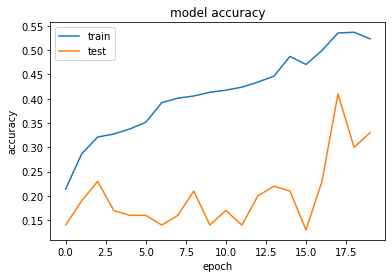

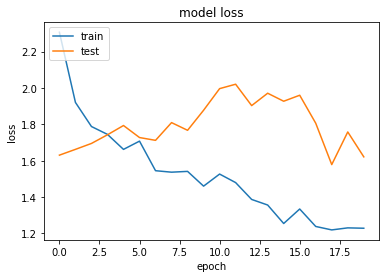

In [101]:
# Plotting the result of Model 3 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [102]:
# Training Accuracy 52%, Validation Accuracy 33%.

### Model-4 : Conv 3D model 
#### Current Model Inputs 
- Increase the image size to 100x100, batch size 18, epoch 25

In [103]:
train_doc = np.random.permutation(open('/home/datasets/Project_data/train.csv').readlines())
val_doc = np.random.permutation(open('/home/datasets/Project_data/val.csv').readlines())

In [104]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,100,100,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes

# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.02)
    
# Resizing the image :    
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)                    
                        
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,100,100,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
# Cropping image by 10 % of original size :
                    image = crop_img(image, 0.02)

# Resizing the image :
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)

# Perform normalization on images
                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels


In [105]:
modelConv3D_4 = Sequential()

modelConv3D_4.add(Conv3D(8, kernel_size=(3,3,3), input_shape=(18,100,100,3),padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))
modelConv3D_4.add(Conv3D(16,kernel_size=(3,3,3), padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))
modelConv3D_4.add(Conv3D(32,kernel_size=(1,3,3),padding='same'))
modelConv3D_4.add(BatchNormalization())
modelConv3D_4.add(Activation('relu'))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))
modelConv3D_4.add(Conv3D(64, kernel_size=(1,3,3), padding='same'))
modelConv3D_4.add(Activation('relu'))
modelConv3D_4.add(Dropout(0.25))

modelConv3D_4.add(MaxPooling3D(pool_size=(2,2,2)))

#Flatten Layers
modelConv3D_4.add(Flatten())

modelConv3D_4.add(Dense(128, activation='relu'))
modelConv3D_4.add(Dropout(0.5))

modelConv3D_4.add(Dense(64, activation='relu'))
modelConv3D_4.add(Dropout(0.25))

#softmax layer
modelConv3D_4.add(Dense(5, activation='softmax'))

In [106]:
import tensorflow as tf
from tensorflow.keras import optimizers

# Define the Adam optimizer with a fixed learning rate
optimiser = optimizers.Adam()  # No decay applied here

# Define your model (make sure your modelConv3D_1 is defined before this)
modelConv3D_4.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(modelConv3D_4.summary())

  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_28 (Conv3D)          (None, 18, 100, 100, 8)   656       
                                                                 
 batch_normalization_39 (Bat  (None, 18, 100, 100, 8)  32        
 chNormalization)                                                
                                                                 
 activation_28 (Activation)  (None, 18, 100, 100, 8)   0         
                                                                 
 max_pooling3d_28 (MaxPoolin  (None, 9, 50, 50, 8)     0         
 g3D)                                                            
                                                                 
 conv3d_29 (Conv3D)          (None, 9, 50, 50, 16)     3472      
                                                              

In [107]:
print("Total Params in model:", modelConv3D_4.count_params())

Total Params in model: 331109


In [108]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

batch_size = 18
num_epochs = 25

train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

# training sequences = 663
# validation sequences = 100


In [109]:
# Get the current date and time for model saving
curr_dt_time = datetime.datetime.now()

# Create model name with current timestamp
model_name = 'model_init_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Check if the directory exists, and create if not
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

# Combine callbacks into a list
callbacks_list

In [110]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1
    

In [111]:
# Model Fit

history = modelConv3D_4.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,
                    workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 18
Epoch 1/25
37/37 [==============================] - ETA: 0s - loss: 1.8493 - categorical_accuracy: 0.2398Source path =  /home/datasets/Project_data/val ; batch size = 18

Epoch 00001: saving model to model_init_2024-11-0606_03_42.713072/model-00001-1.84933-0.23982-1.60785-0.25000.h5
37/37 [==============================] - 28s 735ms/step - loss: 1.8493 - categorical_accuracy: 0.2398 - val_loss: 1.6079 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/25
37/37 [==============================] - ETA: 0s - loss: 1.5779 - categorical_accuracy: 0.2790
Epoch 00002: saving model to model_init_2024-11-0606_03_42.713072/model-00002-1.57788-0.27903-1.60801-0.26000.h5
37/37 [==============================] - 26s 707ms/step - loss: 1.5779 - categorical_accuracy: 0.2790 - val_loss: 1.6080 - val_categorical_accuracy: 0.2600 - lr: 0.0010
Epoch 3/25
37/37 [==============================] - ETA: 0s - loss: 1.5654 - categorical_acc

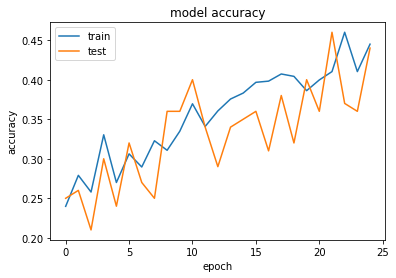

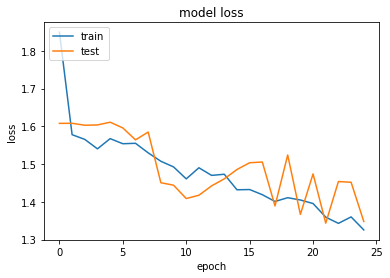

In [112]:
# Plotting the result of Model 4 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [113]:
# Training Accuracy  44%, Validation Accuracy 44%

### Model 5 : Conv 3D model

#### Current Model inputs: 
- batch size 16, increased image inputs to 30 , image size reduced to 84

In [125]:
batch_size = 16

In [126]:
def generator(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)] 
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,84,84,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,84,84,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(84,84),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [127]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 22
print ('# epochs =', num_epochs)

# training sequences = 663
# validation sequences = 100
# epochs = 22


In [128]:
#write your model here

from tensorflow.keras.regularizers import l2

# Model Definition
modelConv3D_5 = Sequential()

# First Conv3D Layer with L2 regularization
modelConv3D_5.add(Conv3D(8, (3,3,3), padding='same', input_shape=(30,84,84,3), kernel_regularizer=l2(0.01)))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

# Second Conv3D Layer with L2 regularization
modelConv3D_5.add(Conv3D(16, (3,3,3), padding='same', kernel_regularizer=l2(0.01)))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

# Third Conv3D Layer with L2 regularization
modelConv3D_5.add(Conv3D(32, (3,3,3), padding='same', kernel_regularizer=l2(0.01)))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

# Fourth Conv3D Layer with L2 regularization
modelConv3D_5.add(Conv3D(64, (3,3,3), padding='same', kernel_regularizer=l2(0.01)))
modelConv3D_5.add(Activation('relu'))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(MaxPooling3D(pool_size=(2,2,2)))

# Flatten and Dense layers with increased dropout
modelConv3D_5.add(Flatten())
modelConv3D_5.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.4))

modelConv3D_5.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
modelConv3D_5.add(BatchNormalization())
modelConv3D_5.add(Dropout(0.4))

# Output Layer
modelConv3D_5.add(Dense(5, activation='softmax'))

In [129]:
import tensorflow as tf
from tensorflow.keras import optimizers

# Define the Adam optimizer with a fixed learning rate
optimiser = optimizers.Adam(learning_rate=0.0001)  # No decay applied here

# Define your model (make sure your modelConv3D_1 is defined before this)
modelConv3D_5.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(modelConv3D_5.summary())


  opt = tf.keras.mixed_precision.LossScaleOptimizer(opt)

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d_36 (Conv3D)          (None, 30, 84, 84, 8)     656       
                                                                 
 activation_36 (Activation)  (None, 30, 84, 84, 8)     0         
                                                                 
 batch_normalization_48 (Bat  (None, 30, 84, 84, 8)    32        
 chNormalization)                                                
                                                                 
 max_pooling3d_36 (MaxPoolin  (None, 15, 42, 42, 8)    0         
 g3D)                                                            
                                                                 
 conv3d_37 (Conv3D)          (None, 15, 42, 42, 16)    3472      
                                                              

In [130]:
print("Total Params in model:", modelConv3D_5.count_params())

Total Params in model: 181285


In [131]:
train_generator = generator(train_path, train_doc, batch_size)
val_generator = generator(val_path, val_doc, batch_size)

In [132]:
# Get the current date and time for model saving
curr_dt_time = datetime.datetime.now()

# Create model name with current timestamp
model_name = 'model_init_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Check if the directory exists, and create if not
if not os.path.exists(model_name):
    os.mkdir(model_name)

filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnPlateau callback
LR = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.001, verbose=1)

# Combine callbacks into a list
callbacks_list

In [133]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [134]:
# Model Fit

history = modelConv3D_5.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,
                    workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/22
42/42 [==============================] - ETA: 0s - loss: 5.1850 - categorical_accuracy: 0.1719Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: saving model to model_init_2024-11-0606_03_42.713072/model-00001-5.18504-0.17195-4.25932-0.23000.h5
42/42 [==============================] - 50s 1s/step - loss: 5.1850 - categorical_accuracy: 0.1719 - val_loss: 4.2593 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 2/22
42/42 [==============================] - ETA: 0s - loss: 4.7841 - categorical_accuracy: 0.2594
Epoch 00002: saving model to model_init_2024-11-0606_03_42.713072/model-00002-4.78407-0.25943-4.29935-0.23000.h5
42/42 [==============================] - 47s 1s/step - loss: 4.7841 - categorical_accuracy: 0.2594 - val_loss: 4.2994 - val_categorical_accuracy: 0.2300 - lr: 1.0000e-04
Epoch 3/22
42/42 [==============================] - ETA: 0s - loss: 4.5809 - categorical_a

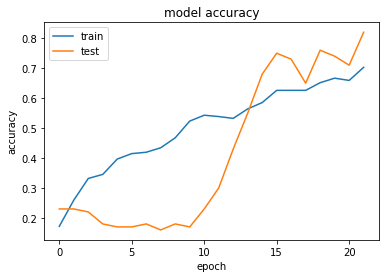

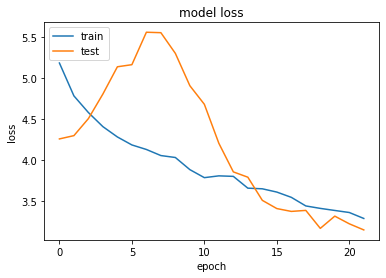

In [135]:
# Plotting the result of Model 5 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [70]:
# Training Accuracy 70%, Validation Accuracy 82%

### Model 6 : TimeDistributed Conv2D+LSTM Model 

In [11]:
# Input
input_shape=(30,100,100,3)

In [12]:
#write your model here
CNNlstm_1 = Sequential()

CNNlstm_1.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
CNNlstm_1.add(TimeDistributed(BatchNormalization()))
CNNlstm_1.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_1.add(TimeDistributed(Flatten()))


CNNlstm_1.add(LSTM(64))
CNNlstm_1.add(Dropout(0.4))

CNNlstm_1.add(Dense(64,activation='relu'))
CNNlstm_1.add(Dropout(0.4))

CNNlstm_1.add(Dense(5, activation='softmax'))

2024-11-06 11:43:14.716353: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 14800 MB memory:  -> device: 0, name: Quadro RTX 5000, pci bus id: 0000:40:00.0, compute capability: 7.5


In [13]:
import tensorflow as tf
from tensorflow.keras import optimizers

# Define the Adam optimizer with a fixed learning rate
optimiser = optimizers.Adam(learning_rate=0.001)  # No decay applied here

# Define your model (make sure your modelConv3D_1 is defined before this)
CNNlstm_1.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(CNNlstm_1.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed (TimeDistr  (None, 30, 100, 100, 16)  448      
 ibuted)                                                         
                                                                 
 time_distributed_1 (TimeDis  (None, 30, 100, 100, 16)  64       
 tributed)                                                       
                                                                 
 time_distributed_2 (TimeDis  (None, 30, 50, 50, 16)   0         
 tributed)                                                       
                                                                 
 time_distributed_3 (TimeDis  (None, 30, 50, 50, 32)   4640      
 tributed)                                                       
                                                                 
 time_distributed_4 (TimeDis  (None, 30, 50, 50, 32)   1

In [14]:
batch_size = 10
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 21
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 21


In [15]:
def generatorLSTM(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,100,100,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,100,100,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(100,100),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [16]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

In [30]:
import datetime
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Get the current date and time for model saving 
curr_dt_time = datetime.datetime.now()

# Create model name with current timestamp
model_name = 'model_init_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Check if the directory exists, and create it if not
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the file path with placeholders for epoch and performance metrics
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnPlateau callback (adjusted to monitor 'val_categorical_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)

# Combine callbacks into a list
callbacks_list = [checkpoint, reduce_lr, early_stopping]

In [31]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [32]:
#Model Fit

history = CNNlstm_1.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,
                    workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 10
Epoch 1/21
67/67 [==============================] - ETA: 0s - loss: 1.5974 - categorical_accuracy: 0.2730Source path =  /home/datasets/Project_data/val ; batch size = 10

Epoch 00001: saving model to model_init_2024-11-0610_03_30.198006/model-00001-1.59742-0.27300-1.72852-0.22000.h5
67/67 [==============================] - 63s 910ms/step - loss: 1.5974 - categorical_accuracy: 0.2730 - val_loss: 1.7285 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/21
67/67 [==============================] - ETA: 0s - loss: 1.4602 - categorical_accuracy: 0.3439
Epoch 00002: saving model to model_init_2024-11-0610_03_30.198006/model-00002-1.46021-0.34389-1.82793-0.18000.h5
67/67 [==============================] - 48s 734ms/step - loss: 1.4602 - categorical_accuracy: 0.3439 - val_loss: 1.8279 - val_categorical_accuracy: 0.1800 - lr: 0.0010
Epoch 3/21
67/67 [==============================] - ETA: 0s - loss: 1.4010 - categorical_acc

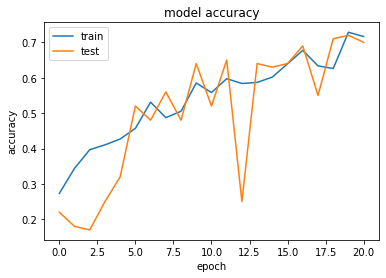

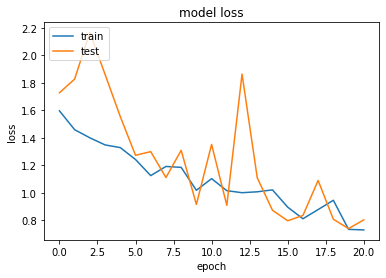

In [33]:
# Plotting the result of Model 6 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [82]:
# Training  Accuracy 71%, Validation Accuracy 70%

### Model 7 : TimeDistributed Conv2D+LSTM Model 
#### Current Model Inputs:
-Increased input image size to 120x120 

In [17]:
# Input
input_shape=(30,120,120,3)


#write your model here
CNNlstm_2 = Sequential()

CNNlstm_2.add(TimeDistributed(Conv2D(16, (3, 3) , padding='same', activation='relu'),
                          input_shape=input_shape))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(32, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(64, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(128, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Conv2D(256, (3, 3) , padding='same', activation='relu')))
CNNlstm_2.add(TimeDistributed(BatchNormalization()))
CNNlstm_2.add(TimeDistributed(MaxPooling2D((2, 2))))

CNNlstm_2.add(TimeDistributed(Flatten()))


CNNlstm_2.add(LSTM(64))
CNNlstm_2.add(Dropout(0.3))

CNNlstm_2.add(Dense(64,activation='relu'))
CNNlstm_2.add(Dropout(0.3))

CNNlstm_2.add(Dense(5, activation='softmax'))

In [18]:
import tensorflow as tf
from tensorflow.keras import optimizers

# Define the Adam optimizer with a fixed learning rate
optimiser = optimizers.Adam(learning_rate=0.001)  # No decay applied here

# Define your model (make sure your modelConv3D_1 is defined before this)
CNNlstm_2.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(CNNlstm_2.summary())

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_16 (TimeDi  (None, 30, 120, 120, 16)  448      
 stributed)                                                      
                                                                 
 time_distributed_17 (TimeDi  (None, 30, 120, 120, 16)  64       
 stributed)                                                      
                                                                 
 time_distributed_18 (TimeDi  (None, 30, 60, 60, 16)   0         
 stributed)                                                      
                                                                 
 time_distributed_19 (TimeDi  (None, 30, 60, 60, 32)   4640      
 stributed)                                                      
                                                                 
 time_distributed_20 (TimeDi  (None, 30, 60, 60, 32)  

In [19]:
print("Total Params in model:", CNNlstm_2.count_params())

Total Params in model: 1005541


In [20]:
def generatorLSTM(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [x for x in range(0, 30)]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,30,120,120,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,30,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [21]:
batch_size = 16
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)
# choose the number of epochs
num_epochs = 16
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 16


In [22]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

In [23]:
import datetime
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Get the current date and time for model saving 
curr_dt_time = datetime.datetime.now()

# Create model name with current timestamp
model_name = 'model_init_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Check if the directory exists, and create it if not
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the file path with placeholders for epoch and performance metrics
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnPlateau callback (adjusted to monitor 'val_categorical_accuracy')
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# EarlyStopping callback
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)

# Combine callbacks into a list
callbacks_list = [checkpoint, reduce_lr, early_stopping]

In [24]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [160]:
# Model Fit

history = CNNlstm_2.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,
                    workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/16
42/42 [==============================] - ETA: 0s - loss: 1.5358 - categorical_accuracy: 0.3394Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: saving model to model_init_2024-11-0608_00_48.646260/model-00001-1.53585-0.33937-1.68070-0.25000.h5
42/42 [==============================] - 53s 1s/step - loss: 1.5358 - categorical_accuracy: 0.3394 - val_loss: 1.6807 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/16
42/42 [==============================] - ETA: 0s - loss: 1.3419 - categorical_accuracy: 0.4299
Epoch 00002: saving model to model_init_2024-11-0608_00_48.646260/model-00002-1.34186-0.42986-2.16703-0.21000.h5
42/42 [==============================] - 50s 1s/step - loss: 1.3419 - categorical_accuracy: 0.4299 - val_loss: 2.1670 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/16
42/42 [==============================] - ETA: 0s - loss: 1.2417 - categorical_accuracy:

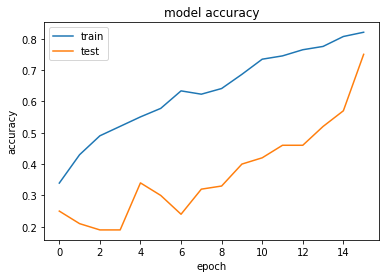

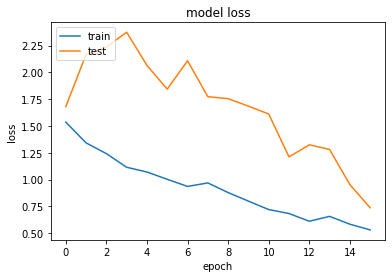

In [162]:
# Plotting the result of Model 7 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')

plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [96]:
# Training Accuracy 82%, Validation Accuracy 75% 

### Model 8 : Conv3D+LSTM Model
#### Current Changes in Model
- Increased layers 

In [25]:
from tensorflow.keras.layers import GlobalAveragePooling3D
input_shape = (30, 120, 120, 3)

CNNlstm_3 = Sequential()
CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same', input_shape=input_shape))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(16, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(32, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(64, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())

CNNlstm_3.add(Conv3D(128, (3,3,3), padding='same'))
CNNlstm_3.add(Activation('relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(MaxPooling3D(pool_size=(2, 2, 2)))

# Replace Flatten with GlobalAveragePooling3D for compatibility
CNNlstm_3.add(GlobalAveragePooling3D())

# Fully connected layers
CNNlstm_3.add(Dense(64, activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.3))

CNNlstm_3.add(Dense(64, activation='relu'))
CNNlstm_3.add(BatchNormalization())
CNNlstm_3.add(Dropout(0.3))

# Output layer
CNNlstm_3.add(Dense(5, activation='softmax'))

In [26]:
import tensorflow as tf
from tensorflow.keras import optimizers

# Define the Adam optimizer with a fixed learning rate
optimiser = optimizers.Adam(learning_rate=0.001)  # No decay applied here

# Define your model (make sure your modelConv3D_1 is defined before this)
CNNlstm_3.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(CNNlstm_3.summary())


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 30, 120, 120, 16)  1312      
                                                                 
 activation (Activation)     (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_10 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                                
                                                                 
 conv3d_1 (Conv3D)           (None, 30, 120, 120, 16)  6928      
                                                                 
 activation_1 (Activation)   (None, 30, 120, 120, 16)  0         
                                                                 
 batch_normalization_11 (Bat  (None, 30, 120, 120, 16)  64       
 chNormalization)                                     

In [27]:
print("Total Params in model:", CNNlstm_3.count_params())

Total Params in model: 894773


In [28]:
curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# choose the number of epochs & batch -size
batch_size = 16
num_epochs = 18
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 18


In [29]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

In [33]:
import datetime
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Get the current date and time for model saving
curr_dt_time = datetime.datetime.now()

# Create model name with current timestamp
model_name = 'model_init_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Check if the directory exists, and create it if not
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the file path with placeholders for epoch and performance metrics
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback - only saves the best model to prevent storage issues
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnPlateau callback - reduces LR if 'val_categorical_accuracy' plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# EarlyStopping callback - stops training early if there's no improvement in 'val_categorical_accuracy'
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)

# Combine callbacks into a list
callbacks_list = [checkpoint, reduce_lr, early_stopping]

In [34]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [35]:
#Model Fit

history = CNNlstm_3.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,
                    workers=1, initial_epoch=0)

Epoch 1/18
42/42 [==============================] - ETA: 0s - loss: 1.2275 - categorical_accuracy: 0.4781
Epoch 00001: val_loss improved from inf to 4.59325, saving model to model_init_2024-11-0611_50_42.907619/model-00001-1.22751-0.47813-4.59325-0.17000.h5
42/42 [==============================] - 50s 1s/step - loss: 1.2275 - categorical_accuracy: 0.4781 - val_loss: 4.5933 - val_categorical_accuracy: 0.1700 - lr: 0.0010
Epoch 2/18
42/42 [==============================] - ETA: 0s - loss: 1.1964 - categorical_accuracy: 0.4857
Epoch 00002: val_loss improved from 4.59325 to 1.96328, saving model to model_init_2024-11-0611_50_42.907619/model-00002-1.19637-0.48567-1.96328-0.43000.h5
42/42 [==============================] - 49s 1s/step - loss: 1.1964 - categorical_accuracy: 0.4857 - val_loss: 1.9633 - val_categorical_accuracy: 0.4300 - lr: 0.0010
Epoch 3/18
42/42 [==============================] - ETA: 0s - loss: 1.0908 - categorical_accuracy: 0.5189
Epoch 00003: val_loss did not improve from

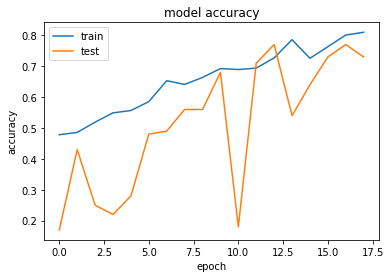

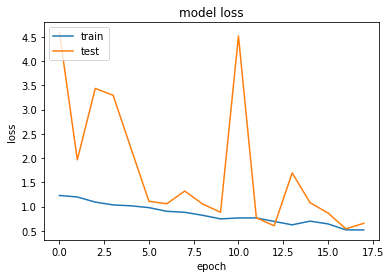

In [39]:
# Plotting the result of Model 8 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [38]:
# Accuracy 81% validation Accuracy 73%

### Model 9 : TimeDistributed Conv2D+GRU LSTM

In [138]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import TimeDistributed, Conv2D, BatchNormalization, MaxPooling2D, GRU, Dropout, Dense, Flatten

input_shape = (30, 120, 120, 3)

GRU_lstm = Sequential()

GRU_lstm.add(TimeDistributed(Conv2D(16, (3, 3), padding='same', activation='relu'), input_shape=input_shape))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(32, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(64, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

GRU_lstm.add(TimeDistributed(Conv2D(128, (3, 3), padding='same', activation='relu')))
GRU_lstm.add(TimeDistributed(BatchNormalization()))
GRU_lstm.add(TimeDistributed(MaxPooling2D((2, 2))))

# Flatten each frame's feature map to prepare it for the GRU layer
GRU_lstm.add(TimeDistributed(Flatten()))

# GRU layer to process temporal sequence
GRU_lstm.add(GRU(64))
GRU_lstm.add(Dropout(0.3))

# Fully connected layers for classification
GRU_lstm.add(Dense(64, activation='relu'))
GRU_lstm.add(Dropout(0.3))

# Output layer with 5 units for classification
GRU_lstm.add(Dense(5, activation='softmax'))

In [139]:
sample_batch = next(train_generator)
print(sample_batch[0].shape)

(16, 30, 120, 120, 3)


In [140]:
import tensorflow as tf
from tensorflow.keras import optimizers

# Define the Adam optimizer with a fixed learning rate
optimiser = optimizers.Adam(learning_rate=0.001)  # No decay applied here

# Define your model (make sure your modelConv3D_1 is defined before this)
GRU_lstm.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(GRU_lstm.summary())

Model: "sequential_11"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_100 (TimeD  (None, 30, 120, 120, 16)  448      
 istributed)                                                     
                                                                 
 time_distributed_101 (TimeD  (None, 30, 120, 120, 16)  64       
 istributed)                                                     
                                                                 
 time_distributed_102 (TimeD  (None, 30, 60, 60, 16)   0         
 istributed)                                                     
                                                                 
 time_distributed_103 (TimeD  (None, 30, 60, 60, 32)   4640      
 istributed)                                                     
                                                                 
 time_distributed_104 (TimeD  (None, 30, 60, 60, 32) 

In [141]:
print("Total Params in model:", GRU_lstm.count_params())

Total Params in model: 1319781


In [142]:
batch_size = 16

curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# choose the number of epochs
num_epochs = 20
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 20


In [143]:
train_generator = generatorLSTM(train_path, train_doc, batch_size)
val_generator = generatorLSTM(val_path, val_doc, batch_size)

In [144]:
import datetime
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau,EarlyStopping

# Get the current date and time for model saving
curr_dt_time = datetime.datetime.now()

# Create model name with current timestamp
model_name = 'model_init_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Check if the directory exists, and create it if not
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the file path with placeholders for epoch and performance metrics
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback - only saves the best model to prevent storage issues
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnPlateau callback - reduces LR if 'val_categorical_accuracy' plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.5, patience=3, min_lr=1e-6, verbose=1)

# EarlyStopping callback - stops training early if there's no improvement in 'val_categorical_accuracy'
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)

# Combine callbacks into a list
callbacks_list = [checkpoint, reduce_lr]

In [145]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [146]:
#Model Fit

history = GRU_lstm.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,
                    workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/20
42/42 [==============================] - ETA: 0s - loss: 1.5234 - categorical_accuracy: 0.3454Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: val_loss improved from inf to 2.07090, saving model to model_init_2024-11-0614_42_26.096959/model-00001-1.52339-0.34540-2.07090-0.22000.h5
42/42 [==============================] - 50s 1s/step - loss: 1.5234 - categorical_accuracy: 0.3454 - val_loss: 2.0709 - val_categorical_accuracy: 0.2200 - lr: 0.0010
Epoch 2/20
42/42 [==============================] - ETA: 0s - loss: 1.3379 - categorical_accuracy: 0.4268
Epoch 00002: val_loss did not improve from 2.07090
42/42 [==============================] - 47s 1s/step - loss: 1.3379 - categorical_accuracy: 0.4268 - val_loss: 2.2607 - val_categorical_accuracy: 0.2100 - lr: 0.0010
Epoch 3/20
42/42 [==============================] - ETA: 0s - loss: 1.2095 - categorical_accuracy: 0.4827
Epoch 00003: va

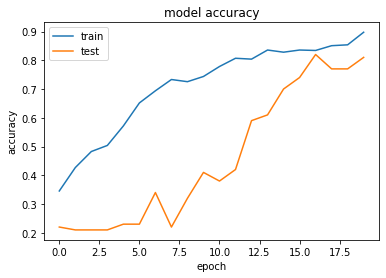

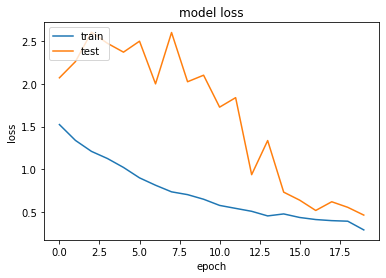

In [147]:
# Plotting the result of Model 9 :

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [119]:
# Accuracy of 89 % and val accuracy of 81 %

### Lets use the pre-trained model for the transfer learning.

### Model 10: Using Transfer Learning

In [148]:
# Importing the transfer learning model:
from keras.applications import mobilenet

mobilenet_transfer = mobilenet.MobileNet(weights='imagenet', include_top=False)

In [149]:
# MobileNet V2 model accepts one of the following formats: (96, 96), (128, 128), (160, 160),(192, 192), or (224, 224).
# Hence, we have got this warning for the input as we have not specified the input size while import.

In [178]:
# Building the model :

input_shape = (18,120,120,3)
        
mobileNetModel= Sequential()
mobileNetModel.add(TimeDistributed(mobilenet_transfer,input_shape=(input_shape)))


for layer in mobileNetModel.layers:
    layer.trainable = False


mobileNetModel.add(TimeDistributed(BatchNormalization()))
mobileNetModel.add(TimeDistributed(MaxPooling2D((2, 2))))
mobileNetModel.add(TimeDistributed(Flatten()))

mobileNetModel.add(LSTM(64))
mobileNetModel.add(Dropout(0.5))

mobileNetModel.add(Dense(64,activation='relu'))
mobileNetModel.add(Dropout(0.5))

mobileNetModel.add(Dense(5, activation='softmax'))


In [179]:
import tensorflow as tf
from tensorflow.keras import optimizers

# Define the Adam optimizer with a fixed learning rate
optimiser = optimizers.Adam(learning_rate=0.001)  # No decay applied here

# Define your model (make sure your modelConv3D_1 is defined before this)
mobileNetModel.compile(optimizer=optimiser, loss='categorical_crossentropy', metrics=['categorical_accuracy'])

# Print the model summary
print(mobileNetModel.summary())

Model: "sequential_14"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 time_distributed_121 (TimeD  (None, 18, 3, 3, 1024)   3228864   
 istributed)                                                     
                                                                 
 time_distributed_122 (TimeD  (None, 18, 3, 3, 1024)   4096      
 istributed)                                                     
                                                                 
 time_distributed_123 (TimeD  (None, 18, 1, 1, 1024)   0         
 istributed)                                                     
                                                                 
 time_distributed_124 (TimeD  (None, 18, 1024)         0         
 istributed)                                                     
                                                                 
 lstm_8 (LSTM)               (None, 64)              

In [180]:
print("Total Params in model:", mobileNetModel.count_params())

Total Params in model: 3516229


In [181]:
def generatorMobileNet(source_path, folder_list, batch_size):
    print( 'Source path = ', source_path, '; batch size =', batch_size)
    
    #create a list of image numbers you want to use for a particular video
    img_idx = [1,2,4,6,7,8,10,12,14,16,18,20,21,22,24,26,27,29]
    #list(range(0,29,2))
    
    while True:
        t = np.random.permutation(folder_list)
        
# calculate the number of batches
        num_batches = int(len(t)/batch_size)
        
# we iterate over the number of batches
        for batch in range(num_batches): 
            
# x is the number of images you use for each video, (y,z) is the final size of the input images and 3 is the number of channels RGB          
            batch_data = np.zeros((batch_size,18,120,120,3))
# batch_labels is the one hot representation of the output
            batch_labels = np.zeros((batch_size,5))

# iterate over the batch_size    
            for folder in range(batch_size): 
# read all the images in the folder        
                imgs = os.listdir(source_path+'/'+ t[folder + (batch*batch_size)].split(';')[0]) 
#  Iterate over the frames/images of a folder to read them in    
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (batch*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    
#crop the images and resize them. Note that the images are of 2 different shape 
#and the conv3D will throw error if the inputs in a batch have different shapes
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                                
#normalise and feed in the image

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255
                    
                batch_labels[folder, int(t[folder + (batch*batch_size)].strip().split(';')[2])] = 1
#you yield the batch_data and the batch_labels, remember what does yield do                
            yield batch_data, batch_labels 

        
# write the code for the remaining data points which are left after full batches
        if (len(t)%batch_size) != 0:
            batch_data = np.zeros((len(t)%batch_size,18,120,120,3))
            batch_labels = np.zeros((len(t)%batch_size,5))
            for folder in range(len(t)%batch_size):
                imgs = os.listdir(source_path+'/'+ t[folder + (num_batches*batch_size)].split(';')[0])
                for idx,item in enumerate(img_idx):
                    image = cv2.imread(source_path+'/'+ t[folder + (num_batches*batch_size)].strip().split(';')[0]+'/'+imgs[item],cv2.IMREAD_UNCHANGED).astype(np.float32)
                    if image.shape[1] == 160:
                        image = cv2.resize(image[:,20:140,:],(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)
                    else:
                        image = cv2.resize(image,(120,120),interpolation = cv2.INTER_AREA).astype(np.float32)

                    batch_data[folder,idx,:,:,0] = (image[:,:,0])/255
                    batch_data[folder,idx,:,:,1] = (image[:,:,1])/255
                    batch_data[folder,idx,:,:,2] = (image[:,:,2])/255

                batch_labels[folder, int(t[folder + (num_batches*batch_size)].strip().split(';')[2])] = 1

            yield batch_data, batch_labels

In [182]:
batch_size = 16

curr_dt_time = datetime.datetime.now()
train_path = '/home/datasets/Project_data/train'
val_path = '/home/datasets/Project_data/val'
num_train_sequences = len(train_doc)
print('# training sequences =', num_train_sequences)
num_val_sequences = len(val_doc)
print('# validation sequences =', num_val_sequences)

# choose the number of epochs
num_epochs = 26
print ('# epochs =', num_epochs)


# training sequences = 663
# validation sequences = 100
# epochs = 26


In [183]:
train_generator = generatorMobileNet(train_path, train_doc, batch_size)
val_generator = generatorMobileNet(val_path, val_doc, batch_size)

In [184]:
import datetime
import os
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau, EarlyStopping

# Get the current date and time for model saving
curr_dt_time = datetime.datetime.now()

# Create model name with current timestamp
model_name = 'model_init_' + str(curr_dt_time).replace(' ', '').replace(':', '_') + '/'

# Check if the directory exists, and create it if not
if not os.path.exists(model_name):
    os.mkdir(model_name)

# Define the file path with placeholders for epoch and performance metrics
filepath = model_name + 'model-{epoch:05d}-{loss:.5f}-{categorical_accuracy:.5f}-{val_loss:.5f}-{val_categorical_accuracy:.5f}.h5'

# ModelCheckpoint callback - only saves the best model to prevent storage issues
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, save_weights_only=False, mode='auto', save_freq='epoch')

# ReduceLROnPlateau callback - reduces LR if 'val_categorical_accuracy' plateaus
reduce_lr = ReduceLROnPlateau(monitor='val_categorical_accuracy', factor=0.6, patience=4, min_lr=1e-6, verbose=1)

# EarlyStopping callback - stops training early if there's no improvement in 'val_categorical_accuracy'
early_stopping = EarlyStopping(monitor='val_categorical_accuracy', patience=5, restore_best_weights=True)

# Combine callbacks into a list
callbacks_list = [checkpoint, reduce_lr]

In [185]:
if (num_train_sequences%batch_size) == 0:
    steps_per_epoch = int(num_train_sequences/batch_size)
else:
    steps_per_epoch = (num_train_sequences//batch_size) + 1

if (num_val_sequences%batch_size) == 0:
    validation_steps = int(num_val_sequences/batch_size)
else:
    validation_steps = (num_val_sequences//batch_size) + 1

In [186]:
#Model Fit

history = mobileNetModel.fit(train_generator, steps_per_epoch=steps_per_epoch, epochs=num_epochs, verbose=1, 
                    callbacks=callbacks_list, validation_data=val_generator, 
                    validation_steps=validation_steps, class_weight=None,
                    workers=1, initial_epoch=0)

Source path =  /home/datasets/Project_data/train ; batch size = 16
Epoch 1/26
42/42 [==============================] - ETA: 0s - loss: 1.6484 - categorical_accuracy: 0.2489Source path =  /home/datasets/Project_data/val ; batch size = 16

Epoch 00001: val_loss improved from inf to 1.53507, saving model to model_init_2024-11-0615_57_30.731634/model-00001-1.64843-0.24887-1.53507-0.25000.h5
42/42 [==============================] - 34s 750ms/step - loss: 1.6484 - categorical_accuracy: 0.2489 - val_loss: 1.5351 - val_categorical_accuracy: 0.2500 - lr: 0.0010
Epoch 2/26
42/42 [==============================] - ETA: 0s - loss: 1.4418 - categorical_accuracy: 0.3710
Epoch 00002: val_loss improved from 1.53507 to 1.28209, saving model to model_init_2024-11-0615_57_30.731634/model-00002-1.44181-0.37104-1.28209-0.58000.h5
42/42 [==============================] - 30s 728ms/step - loss: 1.4418 - categorical_accuracy: 0.3710 - val_loss: 1.2821 - val_categorical_accuracy: 0.5800 - lr: 0.0010
Epoch 3/26

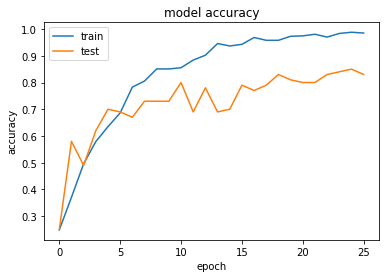

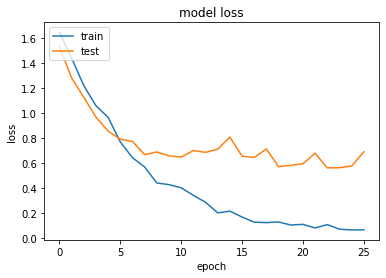

In [187]:
# Plotting the result of Model 10:

# summarize history for accuracy
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

#### Accuracy 98 % and val accuracy of 83 %

## Final Model :

## Transfer Learning 
#### model-00023-0.10598-0.96983-0.56098-0.83000.h5
#### Model has an accuracy of 98%